# SETUP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install corner

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import time

import sys
sys.path.append('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION')

import data_handling_new as data_handling

import corner
import json

import tensorflow as tf

import os
# 1) tell TF to suppress most of its logging before you import it
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # only errors from the C++ backend
import logging
tf.get_logger().setLevel(logging.ERROR)

# 2) import tqdm.auto so it works nicely both in notebooks and in terminals
from tqdm.auto import tqdm

plt.rcParams.update({
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.size": 16,
    # "text.usetex": True,
    "font.family": "sans-serif",
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    #"axes.spines.top": False,
    #"axes.spines.right": False,
    "legend.frameon": False
    #"axes.grid" : True,
    #"grid.color": "gray",
    #"grid.linestyle": "--",
    #"grid.linewidth": 0.5,
    #"grid.alpha": 0.3,
})

# Load

In [4]:
total_number_of_samples = 87419

In [5]:
def load_luvoir_setup():
    luvoir_ds  = data_handling.read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/test.tfrecord", telescope="LUVOIR", batch_size=1)
    model_LUVOIR = tf.keras.models.load_model("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/LUVOIR_NEW.keras")

    x_luvoir = []
    y_luvoir = []
    a_luvouir = []

    for x_batch, y_batch, a_batch in luvoir_ds:
        x_luvoir.append(x_batch)
        y_luvoir.append(y_batch)
        a_luvouir.append(a_batch)

    return x_luvoir, y_luvoir, a_luvouir, model_LUVOIR, luvoir_ds

In [6]:
def load_habex_setup():
    habex_ds  = data_handling.read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/test.tfrecord", telescope="HABEX", batch_size=1)
    model_HABEX = tf.keras.models.load_model("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/HABEX_NEW.keras")

    x_habex = []
    y_habex = []
    a_habex = []

    for x_batch, y_batch, a_batch in habex_ds:
        # if x_batch is a Tensor, convert to NumPy:
        x_habex.append(x_batch)
        y_habex.append(y_batch)
        a_habex.append(a_batch)

    return x_habex, y_habex, a_habex, model_HABEX, habex_ds

In [7]:
x_luvoir, y_luvoir, a_luvouir, model_LUVOIR, luvoir_ds = load_luvoir_setup()
x_habex, y_habex, a_habex, model_HABEX, habex_ds = load_habex_setup()

In [8]:
with open('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json') as f:
    stats = json.load(f)

# Spectrum

In [9]:
uv_b = np.array([0.2       , 0.22857143, 0.26122449, 0.29854227, 0.34119117,
       0.38993277, 0.44563745, 0.50929994])
vis_b = np.array([0.515     , 0.51867857, 0.52238342, 0.52611473, 0.52987269,
       0.5336575 , 0.53746934, 0.5413084 , 0.54517489, 0.549069  ,
       0.55299092, 0.55694085, 0.560919  , 0.56492557, 0.56896075,
       0.57302475, 0.57711779, 0.58124006, 0.58539177, 0.58957314,
       0.59378438, 0.5980257 , 0.60229731, 0.60659943, 0.61093229,
       0.61529609, 0.61969106, 0.62411742, 0.62857541, 0.63306523,
       0.63758712, 0.64214132, 0.64672804, 0.65134753, 0.65600001,
       0.66068572, 0.66540491, 0.6701578 , 0.67494464, 0.67976568,
       0.68462114, 0.6895113 , 0.69443638, 0.69939664, 0.70439233,
       0.7094237 , 0.71449101, 0.71959452, 0.72473448, 0.72991116,
       0.73512481, 0.7403757 , 0.7456641 , 0.75099027, 0.75635448,
       0.76175702, 0.76719814, 0.77267812, 0.77819725, 0.78375581,
       0.78935406, 0.7949923 , 0.80067082, 0.8063899 , 0.81214983,
       0.8179509 , 0.8237934 , 0.82967764, 0.83560391, 0.84157251,
       0.84758374, 0.85363791, 0.85973532, 0.86587629, 0.87206112,
       0.87829013, 0.88456363, 0.89088194, 0.89724539, 0.90365428,
       0.91010895, 0.91660973, 0.92315694, 0.92975092, 0.936392  ,
       0.94308052, 0.9498168 , 0.95660121, 0.96343408, 0.97031575,
       0.97724657, 0.98422691, 0.9912571 , 0.99833751])
nir_b = np.array([1.01      , 1.02442857, 1.03906327, 1.05390703, 1.06896284,
       1.08423374, 1.09972279, 1.11543312, 1.13136788, 1.14753028,
       1.16392356, 1.18055104, 1.19741606, 1.214522  , 1.23187232,
       1.24947049, 1.26732007, 1.28542464, 1.30378785, 1.32241339,
       1.34130501, 1.36046651, 1.37990175, 1.39961463, 1.41960913,
       1.43988926, 1.4604591 , 1.48132281, 1.50248456, 1.52394862,
       1.54571932, 1.56780102, 1.59019818, 1.6129153 , 1.63595694,
       1.65932776, 1.68303244, 1.70707576, 1.73146256, 1.75619774,
       1.78128628, 1.80673322, 1.8325437 , 1.85872289, 1.88527608,
       1.91220859, 1.93952586, 1.96723337, 1.9953367 ])

uv_ss = np.array([0.2       , 0.22857143, 0.26122449, 0.29854227, 0.34119117,
       0.38993277, 0.44563745])
vis_ss = np.array([0.45      , 0.45321429, 0.45645153, 0.4597119 , 0.46299556,
       0.46630267, 0.4696334 , 0.47298792, 0.47636641, 0.47976903,
       0.48319595, 0.48664735, 0.4901234 , 0.49362428, 0.49715017,
       0.50070124, 0.50427768, 0.50787966, 0.51150737, 0.515161  ,
       0.51884072, 0.52254673, 0.5262792 , 0.53003834, 0.53382433,
       0.53763736, 0.54147762, 0.54534532, 0.54924065, 0.55316379,
       0.55711496, 0.56109436, 0.56510217, 0.56913862, 0.57320389,
       0.57729821, 0.58142176, 0.58557478, 0.58975745, 0.59397001,
       0.59821265, 0.6024856 , 0.60678907, 0.61112327, 0.61548844,
       0.61988479, 0.62431253, 0.62877191, 0.63326314, 0.63778645,
       0.64234206, 0.64693022, 0.65155115, 0.65620509, 0.66089227,
       0.66561293, 0.6703673 , 0.67515564, 0.67997818, 0.68483517,
       0.68972685, 0.69465347, 0.69961528, 0.70461253, 0.70964548,
       0.71471438, 0.71981948, 0.72496105, 0.73013934, 0.73535462,
       0.74060715, 0.7458972 , 0.75122504, 0.75659093, 0.76199516,
       0.76743798, 0.77291968, 0.77844053, 0.78400082, 0.78960083,
       0.79524083, 0.80092113, 0.80664199, 0.81240372, 0.8182066 ,
       0.82405094, 0.82993701, 0.83586514, 0.8418356 , 0.84784871,
       0.85390477, 0.86000409, 0.86614698, 0.87233374, 0.8785647 ,
       0.88484016, 0.89116045, 0.89752588, 0.90393678, 0.91039347,
       0.91689628, 0.92344554, 0.93004158, 0.93668473, 0.94337534,
       0.95011373, 0.95690026, 0.96373526, 0.97061909])
nir_ss = np.array([0.975     , 0.999375  , 1.02435937, 1.04996836, 1.07621757,
       1.10312301, 1.13070108, 1.15896861, 1.18794282, 1.2176414 ,
       1.24808243, 1.27928449, 1.3112666 , 1.34404827, 1.37764947,
       1.41209071, 1.44739298, 1.4835778 , 1.52066725, 1.55868393,
       1.59765103, 1.63759231, 1.67853211, 1.72049542, 1.7635078 ])

In [10]:
mean_b = {
    'UV': stats['inputs']['B-UV']['mean'],
    'Vis': stats['inputs']['B-Vis']['mean'],
    'NIR': stats['inputs']['B-NIR']['mean'],
}
std_b = {
    'UV': stats['inputs']['B-UV']['std'],
    'Vis': stats['inputs']['B-Vis']['std'],
    'NIR': stats['inputs']['B-NIR']['std'],
}

mean_ss = {
    'UV': stats['inputs']['SS-UV']['mean'],
    'Vis': stats['inputs']['SS-Vis']['mean'],
    'NIR': stats['inputs']['SS-NIR']['mean'],
}
std_ss = {
    'UV': stats['inputs']['SS-UV']['std'],
    'Vis': stats['inputs']['SS-Vis']['std'],
    'NIR': stats['inputs']['SS-NIR']['std'],
}

In [11]:
def get_spectrum_data(sample):
    wave_axis_b = np.concatenate([uv_b, vis_b, nir_b])
    wave_axis_ss = np.concatenate([uv_ss, vis_ss, nir_ss])

    uv_b_noisy  = x_luvoir[sample]['NOISY_ALBEDO_B-UV'].numpy().squeeze()
    vis_b_noisy = x_luvoir[sample]['NOISY_ALBEDO_B-Vis'].numpy().squeeze()
    nir_b_noisy = x_luvoir[sample]['NOISY_ALBEDO_B-NIR'].numpy().squeeze()

    uv_b_noisy_real  = uv_b_noisy  * std_b['UV']  + mean_b['UV']
    vis_b_noisy_real = vis_b_noisy * std_b['Vis'] + mean_b['Vis']
    nir_b_noisy_real = nir_b_noisy * std_b['NIR'] + mean_b['NIR']

    albedo_b_noisy_real = np.concatenate([uv_b_noisy_real, vis_b_noisy_real, nir_b_noisy_real])

    uv_ss_noisy  = x_habex[sample]['NOISY_ALBEDO_SS-UV'].numpy().squeeze()
    vis_ss_noisy = x_habex[sample]['NOISY_ALBEDO_SS-Vis'].numpy().squeeze()
    nir_ss_noisy = x_habex[sample]['NOISY_ALBEDO_SS-NIR'].numpy().squeeze()

    uv_ss_noisy_real  = uv_ss_noisy  * std_ss['UV']  + mean_ss['UV']
    vis_ss_noisy_real = vis_ss_noisy * std_ss['Vis'] + mean_ss['Vis']
    nir_ss_noisy_real = nir_ss_noisy * std_ss['NIR'] + mean_ss['NIR']

    albedo_ss_noisy_real = np.concatenate([uv_ss_noisy_real, vis_ss_noisy_real, nir_ss_noisy_real])

    albedo_b_clean = np.concatenate([
        a_luvouir[sample]['ALBEDO_B-UV'].numpy().squeeze(),
        a_luvouir[sample]['ALBEDO_B-Vis'].numpy().squeeze(),
        a_luvouir[sample]['ALBEDO_B-NIR'].numpy().squeeze()
    ])

    albedo_ss_clean = np.concatenate([
        a_habex[sample]['ALBEDO_SS-UV'].numpy().squeeze(),
        a_habex[sample]['ALBEDO_SS-Vis'].numpy().squeeze(),
        a_habex[sample]['ALBEDO_SS-NIR'].numpy().squeeze()
    ])

    return wave_axis_b, wave_axis_ss, albedo_b_noisy_real, albedo_ss_noisy_real, albedo_b_clean, albedo_ss_clean

# Corner Plots

In [12]:
def denorm_physical(processed, name):
    pmin, pmax, n = (stats['outputs'][name][k]
                     for k in ('min', 'max', 'best_n'))
    return (processed ** n) * (pmax - pmin) + pmin

def denorm_chem(processed, name):
    n = stats['outputs'][name]['best_n']
    return processed ** n

In [13]:
def get_matrix_coords(n, mode="inclusive"):
    """
    Return a list of (i, j) index pairs for an n x n matrix region.

    Parameters
    ----------
    n : int
        Size of the square matrix.
    mode : str, optional
        One of:
          - "inclusive":  lower triangle including diagonal  (i >= j)
          - "strict":     lower triangle excluding diagonal  (i >  j)
          - "diagonal":   main diagonal only                (i == j)
        Default is "inclusive".

    Returns
    -------
    coords : list of tuple of int
        All (i, j) pairs in the requested region.
    """
    if mode == "inclusive":
        # i >= j
        return [(i, j) for i in range(n) for j in range(i+1)]
    elif mode == "strict":
        # i > j
        return [(i, j) for i in range(n) for j in range(i)]
    elif mode == "diagonal":
        # i == j
        return [(i, i) for i in range(n)]
    else:
        raise ValueError(f"mode must be 'inclusive', 'strict' or 'diagonal', got {mode!r}")

In [14]:
def map_matrix_val(n: int, selected_val: int) -> tuple[int,int]:
    """
    Map a linear index into the full nxn matrix in row-major order:
      selected_val = 0 → (0,0)
      selected_val = 1 → (0,1)
      ...
      selected_val = n → (1,0)
      ...
      selected_val = n*n-1 → (n-1,n-1)

    Raises ValueError if selected_val is out of [0..n*n-1].
    """
    total = n * n
    if not (0 <= selected_val < total):
        raise ValueError(f"selected_val must be in [0..{total-1}], got {selected_val}")
    i = selected_val // n
    j = selected_val % n
    return i, j

In [109]:
def plot_corner_two_models_new_2(pred1, pred2, y_test, sample,
                           plot_true=False, verbose=False,
                           normalize=False,
                           labels=None, exclude_O2O3=False):
    """
    pred1, pred2: two `predictions` dicts from your model calls
    colors: tuple of (color1, color2)
    labels: list of D labels, if None we’ll auto-build from y_test
    """

    # 4) Denormalize data
    record_phys = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY", "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
    record_main = ["O2", "O3"]
    record_other = ["CH4","CO2","H2O","N2O"]
    chem_names = record_main + record_other

    # Denorm y_truths
    def denorm_y(y_param, param_type):
        if param_type == 'physical':
            y_true_norm = [denorm_physical(y_param[j], record_phys[j]) for j in range(len(y_param))]
        elif param_type == 'chemical':
            y_true_norm = [denorm_chem(y_param[j], chem_names[j]) for j in range(len(y_param))]
        else:
            raise Exception('Invalid param')
        return y_true_norm

    # --- 2) ground‐truth vector and labels ----------------------------
    y_phys  = y_test['physical_output'].numpy().reshape(-1)
    y_main  = y_test['main_chemical_output'].numpy().reshape(-1)
    y_other = y_test['other_chemical_output'].numpy().reshape(-1)
    y_chem = np.concatenate([y_main, y_other], axis=0)

    y_phys = np.array(denorm_y(y_phys, 'physical'))
    y_chem = np.array(denorm_y(y_chem, 'chemical'))

    offset = 1e-12
    y_chem   = np.log10(y_chem+offset)

    y_all  = np.concatenate([y_phys, y_chem], axis=0)


    # --- 1) pull out & concatenate all three outputs for both models ---
    def build_all(pred):
        phys = pred['physical_output'].numpy()   # (num_mc,4)
        main = pred['main_chemical_output'].numpy()  # (num_mc,2)
        other= pred['other_chemical_output'].numpy() # (num_mc,4)
        chem = np.concatenate([main, other], axis=1)
        return phys, chem

    phys1, chem1 = build_all(pred1)
    phys2, chem2 = build_all(pred2)

    def denorm_pred(pred_param, param_type, num_features):
        pred_norm = []
        if param_type == 'physical':
            for i in range(len(pred_param)):
                line = [denorm_physical(pred_param[i][j], record_phys[j]) for j in range(num_features)]
                pred_norm.append(line)
        elif param_type == 'chemical':
            for i in range(len(pred_param)):
                line = [denorm_chem(pred_param[i][j], chem_names[j]) for j in range(num_features)]
                pred_norm.append(line)
        else:
            raise Exception('Invalid param')
        return pred_norm

    phys1 = np.array(denorm_pred(phys1, 'physical', len(y_phys)))
    chem1 = np.array(denorm_pred(chem1, 'chemical', len(y_chem)))
    phys2 = np.array(denorm_pred(phys2, 'physical', len(y_phys)))
    chem2 = np.array(denorm_pred(chem2, 'chemical', len(y_chem)))

    chem1 = np.log10(chem1+offset)
    chem2 = np.log10(chem2+offset)

    all1 = np.concatenate([phys1, chem1], axis=1)
    all2 = np.concatenate([phys2, chem2], axis=1)

    D = y_all.shape[0]
    if labels is None:
        # make your own labels if you want
        physical_features = [r"$R_{\oplus}$", r"$g$", r"$T_{\mathrm{atm}}$", r"$P_{\mathrm{atm}}$"]
        main_names = [r"O$_2$", r"O$_3$"]
        other_names = [r"CH$_4$", r"CO$_2$", r"H$_2$O", r"N$_2$"]
        labels = physical_features + main_names + other_names

    if exclude_O2O3:
        idx_O2 = labels.index(r"O$_2$")
        idx_O3 = labels.index(r"O$_3$")
        idx_remove = sorted([idx_O2, idx_O3], reverse=True)
        for idx in idx_remove:
            labels.pop(idx)
        y_all = np.delete(y_all, idx_remove, axis=0)
        all1  = np.delete(all1, idx_remove, axis=1)
        all2  = np.delete(all2, idx_remove, axis=1)

    D = y_all.shape[0]

    # --- 4) corner plot for model1 only -------------------------------
    fig = corner.corner(
        all1,
        labels=labels,
        color="tab:orange", #<< COR
        plot_density=False,
        plot_datapoints=True,
        fill_contours=True,
        smooth=0.9,
        truths=y_all if plot_true else None,
        truth_color='tab:red',
        truth_kwargs={'linewidth':3,'linestyle':'--'},
        truth_point_kwargs={'marker':'x','s':150},
        show_titles=True,
        max_n_ticks=3,
        title_fmt=".2f",
        quantiles=[0.16,0.5,0.84]
    )
    #fig.suptitle(f"MC-Dropout Posteriors (sample {sample})", y=1.02)


    # --- 5) grab the axes in a D×D array -----------------------------
    axes = np.array(fig.axes).reshape((D, D))

    # --- 6) overlay model2 --------------------------------------------
    corner.corner(
        all2,
        labels=labels,
        plot_density=False,
        plot_datapoints=True,
        fill_contours=True,
        smooth=0.9,
        color="k",           # blue-ish
        fig=fig,
        truths=None,
        max_n_ticks=3,
        quantiles=[0.16,0.5,0.84] # ~ 1sigma
    )

    strict_triangle = get_matrix_coords(D, mode="strict")
    diagonal = get_matrix_coords(D, mode="diagonal")

    means1 = all1.mean(axis=0)
    stds1  = all1.std(axis=0)
    means2 = all2.mean(axis=0)
    stds2  = all2.std(axis=0)

    # for ax_index, ax in enumerate(fig.get_axes()):
    #     coord = map_matrix_val(D, ax_index)
    #     j, i = coord

    #     if coord in diagonal:
    #         for means, stds, col in [(means1, stds1, "tab:blue"), (means2, stds2, "k")]:
    #             lower_limit = means[i] - stds[i]
    #             higher_limit = means[i] + stds[i]
    #             # ax.axvspan(lower_limit, higher_limit, facecolor=col, alpha=0.2)
    #             ax.axvline(lower_limit, color=col, linestyle=":", lw=2.2)
    #             ax.axvline(higher_limit, color=col, linestyle=":", lw=2.2)

    #     elif coord in strict_triangle:
    #         for means, stds, col in [(means1, stds1, "tab:blue"), (means2, stds2, "k")]:
    #             # vertical at feature i ±1σ
    #             lower_x_limit = means[i] - stds[i]
    #             higher_x_limit = means[i] + stds[i]
    #             # ax.axvspan(lower_x_limit, higher_x_limit, facecolor=col, alpha=0.2)
    #             ax.axvline(lower_x_limit, color=col, linestyle=":", lw=2.2)
    #             ax.axvline(higher_x_limit, color=col, linestyle=":", lw=2.2)

    #             # horizontal at feature j ±1σ
    #             lower_y_limit = means[j] - stds[j]
    #             higher_y_limit = means[j] + stds[j]
    #             # ax.axhspan(lower_y_limit, higher_y_limit, facecolor=col, alpha=0.2)
    #             ax.axvline(lower_y_limit, color=col, linestyle=":", lw=2.2)
    #             ax.axvline(higher_y_limit, color=col, linestyle=":", lw=2.2)


    # --- 6.5) Plot os espectros -------
    wave_axis_b, wave_axis_ss, albedo_b_noisy_real, albedo_ss_noisy_real, albedo_b_clean, albedo_ss_clean = get_spectrum_data(sample)

    #    these numbers [left, bottom, width, height] are fractions of the full figure
    left, bottom = 0.60, 0.60
    width, height = 0.35, 0.30

    # 2) split that box into two halves:
    h2 = height/2

    # top‐half axes for “b” spectrum
    ax_b = fig.add_axes([left, bottom + h2, width, h2])
    # bottom‐half axes for “ss” spectrum
    ax_ss = fig.add_axes([left, bottom, width, h2])

    # 3) plot each spectrum in its own small axes:
    lw = 2.2
    dots_size = 14

    # --- “b” panel ---
    ax_b.scatter(wave_axis_b, albedo_b_noisy_real,
                color='tab:gray', alpha=0.6, s=dots_size)
    #uv_seg  = wave_axis_b[:len(uv_b)],  albedo_b_clean[:len(uv_b)]
    #vis_seg = wave_axis_b[len(uv_b):len(uv_b)+len(vis_b)], albedo_b_clean[len(uv_b):len(uv_b)+len(vis_b)]
    #nir_seg = wave_axis_b[-len(nir_b):], albedo_b_clean[-len(nir_b):]
    ax_b.text(1.5, 0.3, 'LUVOIR-B', fontsize=20)

    last_uv_b  = uv_b[-1]    # 0.50929994
    last_vis_b = vis_b[-1]   # 0.99833751

    uv_mask_b  = wave_axis_b <= last_uv_b
    vis_mask_b = (wave_axis_b > last_uv_b) & (wave_axis_b <= last_vis_b)
    nir_mask_b = wave_axis_b > last_vis_b

    uv_seg_b  = wave_axis_b[uv_mask_b], albedo_b_clean[uv_mask_b]
    vis_seg_b = wave_axis_b[vis_mask_b], albedo_b_clean[vis_mask_b]
    nir_seg_b = wave_axis_b[nir_mask_b], albedo_b_clean[nir_mask_b]

    ax_b.plot(*uv_seg_b,  color='tab:blue',   lw=lw)
    ax_b.plot(*vis_seg_b, color='tab:orange', lw=lw)
    ax_b.plot(*nir_seg_b, color='tab:green',  lw=lw)
    ax_b.axvline(wave_axis_b[len(uv_b)],            color='gray', linestyle='--')
    ax_b.axvline(wave_axis_b[len(uv_b)+len(vis_b)], color='gray', linestyle='--')
    ax_b.set_ylabel('Apparent Albedo', fontsize=18)
    ax_b.tick_params(axis='y', which='both', labelsize=18)
    ax_b.get_xaxis().set_visible(False)

    # --- “ss” panel ---
    ax_ss.scatter(wave_axis_ss, albedo_ss_noisy_real,
                color='tab:gray', alpha=0.6, s=dots_size)
    ax_ss.text(1.5, 0.15, 'HabEx/SS', fontsize=20)
    #uv_seg_ss  = wave_axis_ss[:len(uv_ss)],  albedo_ss_clean[:len(uv_ss)]
    #vis_seg_ss = wave_axis_ss[len(uv_ss):len(uv_ss)+len(vis_ss)], albedo_ss_clean[len(uv_ss):len(uv_ss)+len(vis_ss)]
    #nir_seg_ss = wave_axis_ss[-len(nir_ss):],   albedo_ss_clean[-len(nir_ss):]

    last_uv_ss  = uv_ss[-1]   # 0.44563745
    last_vis_ss = vis_ss[-1]  # 0.97061909

    uv_mask_ss  = wave_axis_ss <= last_uv_ss
    vis_mask_ss = (wave_axis_ss > last_uv_ss) & (wave_axis_ss <= last_vis_ss)
    nir_mask_ss = wave_axis_ss > last_vis_ss

    uv_seg_ss  = wave_axis_ss[uv_mask_ss], albedo_ss_clean[uv_mask_ss]
    vis_seg_ss = wave_axis_ss[vis_mask_ss], albedo_ss_clean[vis_mask_ss]
    nir_seg_ss = wave_axis_ss[nir_mask_ss], albedo_ss_clean[nir_mask_ss]

    ax_ss.plot(*uv_seg_ss,  color='tab:blue',   lw=lw)
    ax_ss.plot(*vis_seg_ss, color='tab:orange', lw=lw)
    ax_ss.plot(*nir_seg_ss, color='tab:green',  lw=lw)
    ax_ss.axvline(wave_axis_ss[len(uv_ss)],            color='gray', linestyle='--')
    ax_ss.axvline(wave_axis_ss[len(uv_ss)+len(vis_ss)], color='gray', linestyle='--')
    ax_ss.set_xlabel(r'Wavelength [$\mu$m]', fontsize=18)
    ax_ss.set_ylabel('Apparent Albedo', fontsize=18)
    ax_ss.tick_params(axis='both', which='both', labelsize=18)

    max_lambda = max(wave_axis_b.max(), wave_axis_ss.max())
    ax_b.set_xlim(0.2, max_lambda)
    ax_ss.set_xlim(0.2, max_lambda)

    # 4) redraw
    fig.canvas.draw()

    # --- 7) optionally print limits + truth --------------------------
    if verbose:
        for i in range(D):
            ax = axes[i, i]
            x0, x1 = ax.get_xlim()
            print(f"Dim {i} ({labels[i]}) → xlim=({x0:.3f},{x1:.3f}), "
                  f"truth={y_all[i]:.3f}")
        # example 2D panel
        j, i = 2, 3
        ax2d = axes[j, i]
        print("Panel y={} vs x={} → xlim={}, ylim={}".format(
            labels[j], labels[i],
            ax2d.get_xlim(), ax2d.get_ylim()
        ))

    # --- 8) optional padding to include truths -----------------------
    if plot_true:
        for i in range(D):
            ax = axes[i, i]
            x0, x1 = ax.get_xlim()
            t = y_all[i]
            pad = 0.05*(x1-x0)
            ax.set_xlim(min(x0,t)-pad, max(x1,t)+pad)

        for row in range(D):
            for col in range(D):
                if row==col: continue
                ax = axes[row, col]
                x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
                tx, ty = y_all[col], y_all[row]
                padx = 0.05*(x1-x0); pady = 0.05*(y1-y0)
                ax.set_xlim(min(x0,tx)-padx, max(x1,tx)+padx)
                ax.set_ylim(min(y0,ty)-pady, max(y1,ty)+pady)

    # --- 9) legend ----------------------------------------------------
    proxy1 = Line2D([0],[0], color='tab:orange', lw=2) # << COR
    proxy2 = Line2D([0],[0], color='k', lw=2)
    fig.legend(
      [proxy1, proxy2],
      ['LUVOIR-B','HabEx/SS'],
      loc='upper center',
      bbox_to_anchor=(0.25, 1),
      frameon=False,
      fontsize=20)

    for ax in fig.get_axes():

        if ax in [ax_b, ax_ss]:
            continue  # pula esses axes extras dos espectros

        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        title = ax.get_title()
        if title:
            ax.set_title(title, fontsize=15)

        for label in ax.get_xticklabels():
            label.set_rotation(90)
        for label in ax.get_yticklabels():
            label.set_rotation(0)

        xlabel = ax.xaxis.get_label()
        ylabel = ax.yaxis.get_label()

        xlabel_pos = xlabel.get_position()
        ylabel_pos = ylabel.get_position()

        xlabel.set_position((xlabel_pos[0], xlabel_pos[1] - 0.2))
        ylabel.set_position((ylabel_pos[0] - 0.2, ylabel_pos[1]))

    plt.savefig("cornerplot.pdf", bbox_inches='tight')
    plt.show()

In [97]:
def corner_plots_all(x_luv, y_luv, mod_luv,
                     x_hab, y_hab, mod_hab,
                     sample='random', num_mc=1000,
                     verbose=False, exclude_O2O3=False):

    if sample == 'random':
        sample = np.random.randint(low = 0, high=total_number_of_samples)

    x_luv_test = x_luv[sample]
    x_hab_test = x_hab[sample]

    y_test = y_luv[sample]

    tiled_x_luv = {k: tf.repeat(v, repeats=num_mc, axis=0) for k, v in x_luv_test.items()}
    tiled_x_hab = {k: tf.repeat(v, repeats=num_mc, axis=0) for k, v in x_hab_test.items()}

    pred_luv = mod_luv(tiled_x_luv, training=True)
    pred_hab = mod_hab(tiled_x_hab, training=True)

    plot_corner_two_models_new_2(pred_luv, pred_hab, y_test, plot_true=True, verbose=verbose, sample=sample, exclude_O2O3=exclude_O2O3)

In [98]:
# THE BEST MODERN = 10785
# THE BEST PROTEROZOIC = 8925
# THE BEST ARCHEAN = 25006

# THE WORST MORDERN = 25639
# THE WORST PROTEROZOIC = 21497
# THE WORST ARCHEAN = 3995

modern_start_index = 0
proterozoic_start_index = 35503
archean_start_index = 58860

best_sample_index = archean_start_index + 25006
worst_sample_index = archean_start_index + 3995

Dim 0 ($R_{\oplus}$) → xlim=(0.998,1.212), truth=1.158
Dim 1 ($g$) → xlim=(9.648,13.471), truth=12.267
Dim 2 ($T_{\mathrm{atm}}$) → xlim=(273.584,291.717), truth=276.994
Dim 3 ($P_{\mathrm{atm}}$) → xlim=(983.948,1919.368), truth=1643.146
Dim 4 (CH$_4$) → xlim=(-5.458,-2.709), truth=-4.570
Dim 5 (CO$_2$) → xlim=(-4.504,-2.281), truth=-3.609
Dim 6 (H$_2$O) → xlim=(-5.579,-3.385), truth=-4.893
Dim 7 (N$_2$) → xlim=(-0.510,0.000), truth=-0.009
Panel y=$T_{\mathrm{atm}}$ vs x=$P_{\mathrm{atm}}$ → xlim=(np.float64(0.0), np.float64(1.0)), ylim=(np.float64(0.0), np.float64(1.0))


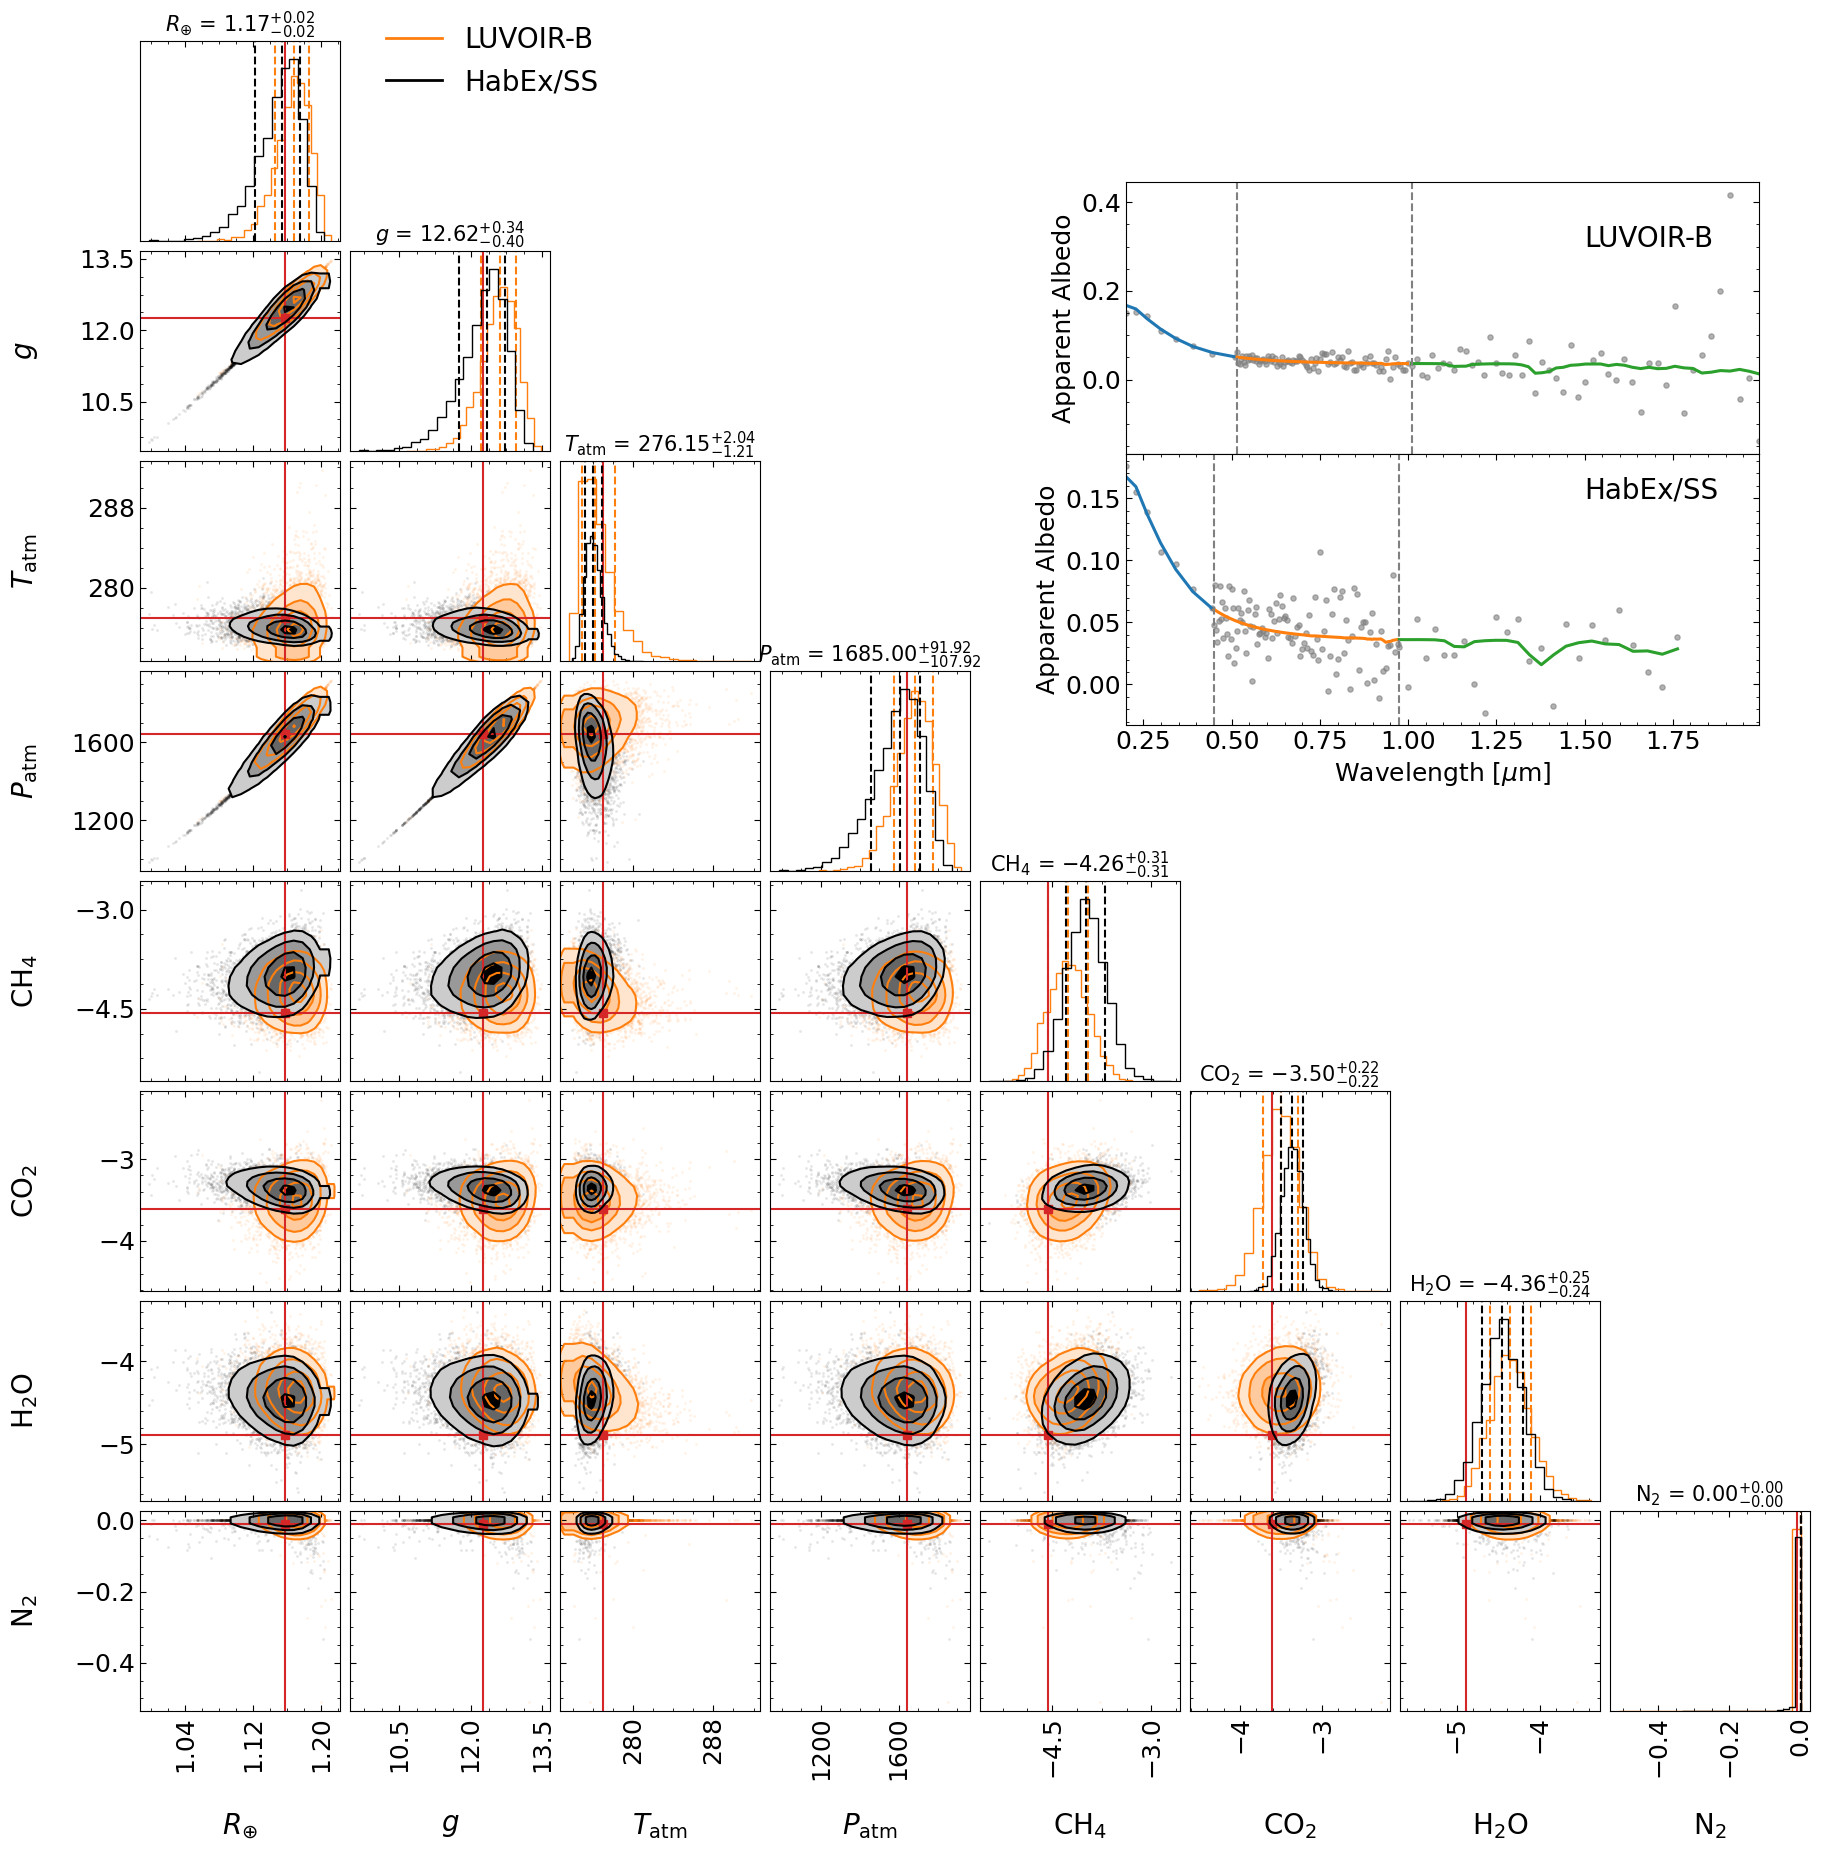

Total time 9.41s


In [110]:
start = time.time()

predictions = corner_plots_all(x_luvoir, y_luvoir, model_LUVOIR,
                               x_habex, y_habex, model_HABEX,
                               sample=best_sample_index, num_mc=5000, verbose=True, exclude_O2O3=True)
end = time.time()

print(f"Total time {end - start:.2f}s")